# Testing Refactored model

In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import Model
from Model import FrequencyDependentModel
from Model.LBFGS_freq_model import FrequencyDependentModel2
from Model.back_prop_utils import H_th_function, round_to_sig_figs, c, torch_unwrap
from Model.plotting_utils import plot_transfer, plot_comparison, plot_training_progress
from Model.loss_functions import loss, complex_transfer_loss, complex_real_imag_loss, log_complex_loss

In [2]:
thickness = 3 * 1e-3

# Setup frequency arrays
frequency_bounds = [0.3, 2]
full_w_THz = np.linspace(0,frequency_bounds[1], 1000)
full_w_THz = torch.tensor(full_w_THz, dtype=torch.float32)

# Convert to angular freqs for calcs
full_w = full_w_THz * 2 * np.pi * 1e12

# Test FrequencyDependentModel methods

## Set up Frequency dependent n & k and Transfer Function

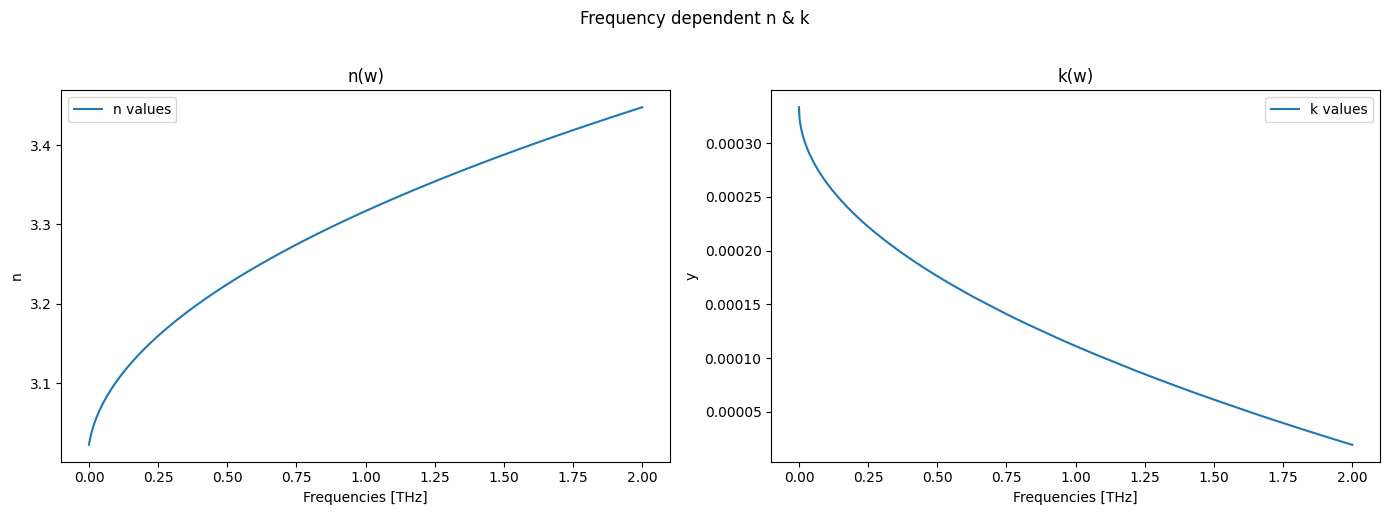

In [3]:
n = np.sqrt(0.1 * (full_w_THz + 0.005)) + 3
k = ((np.sqrt(0.000004 * full_w_THz) + 3)**-1) - 0.333

# Create the first subplot (assuming 'data1' is your first dataset)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# First plot: Approximate values of n from NR solution
sns.lineplot(x=full_w_THz, y=n, label="n values", ax=ax1)
ax1.set_title('n(w)')
ax1.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
ax1.set_xlabel('Frequencies [THz]')
ax1.set_ylabel('n')

# Second plot (assuming 'data2' is your second dataset with x and y values)
sns.lineplot(x=full_w_THz, y=k, label="k values", ax=ax2)
ax2.set_title('k(w)')
ax2.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
ax2.set_xlabel('Frequencies [THz]')
ax2.set_ylabel('y')

# Adjust layout and add main title if needed
plt.suptitle('Frequency dependent n & k', y=1.02)
plt.tight_layout()
plt.legend()
plt.show()

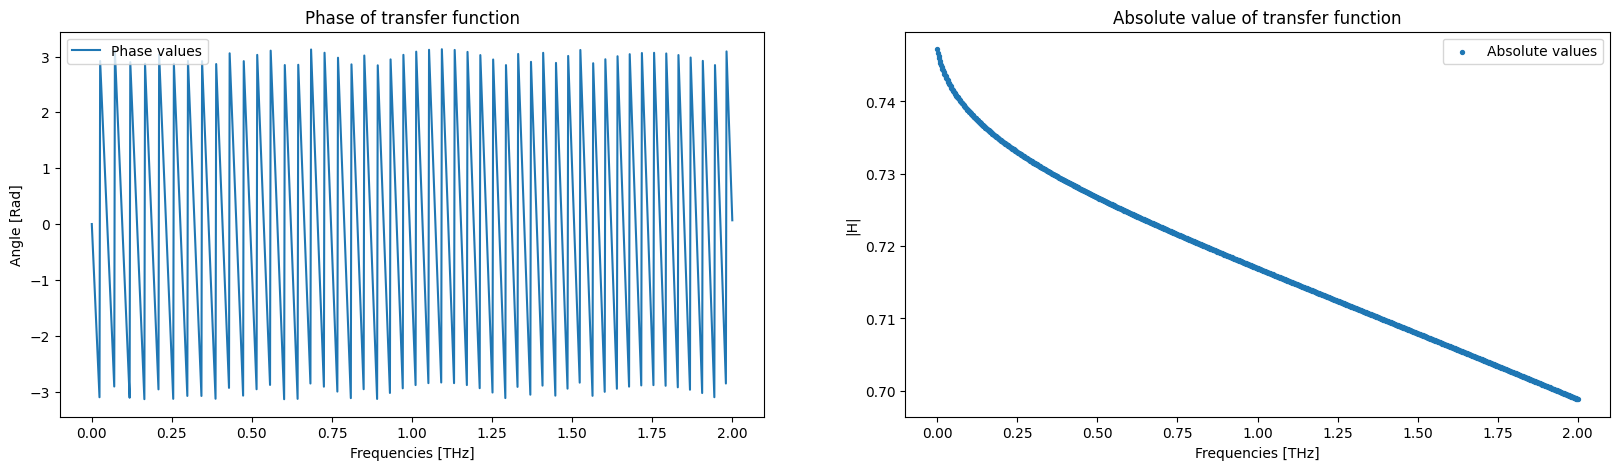

In [4]:
n_complex = n + 1j*k

freq_dep_H = H_th_function(n_complex, w=full_w, length=thickness)

# Break down into components
freq_dep_H_abs = torch.abs(freq_dep_H)
freq_dep_H_phase = torch.angle(freq_dep_H)

plot_transfer(full_w_THz, absolute_values=freq_dep_H_abs, phase_values=freq_dep_H_phase)

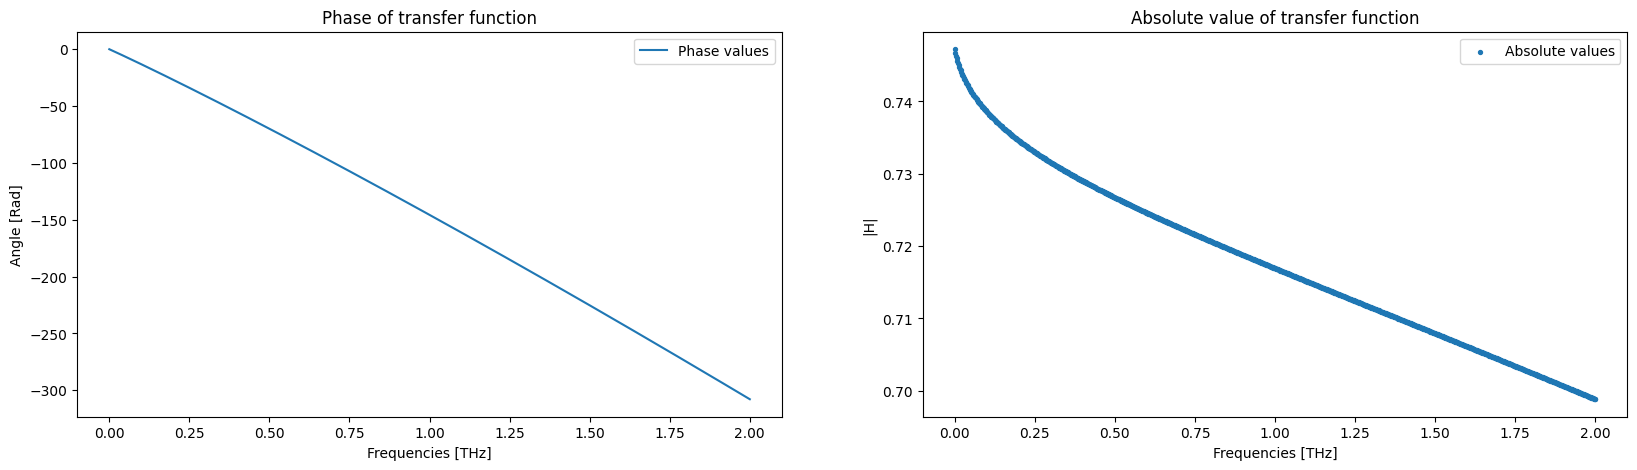

In [5]:
freq_dep_H_phi = torch_unwrap(torch.angle(freq_dep_H))
plot_transfer(full_w_THz, absolute_values=freq_dep_H_abs, phase_values=freq_dep_H_phi)

## Initialize Frequency dependent Model

Epoch 0: Loss = 5.809986591339111 (Best Loss = 5.809986591339111)
Epoch 500: Loss = 0.18488790094852448 (Best Loss = 0.18488790094852448)
Epoch 1000: Loss = 0.07402899861335754 (Best Loss = 0.07402899861335754)
Epoch 1500: Loss = 0.04100119695067406 (Best Loss = 0.04100119695067406)
Epoch 2000: Loss = 0.027542876079678535 (Best Loss = 0.027542876079678535)
Epoch 2500: Loss = 0.020675547420978546 (Best Loss = 0.020675547420978546)


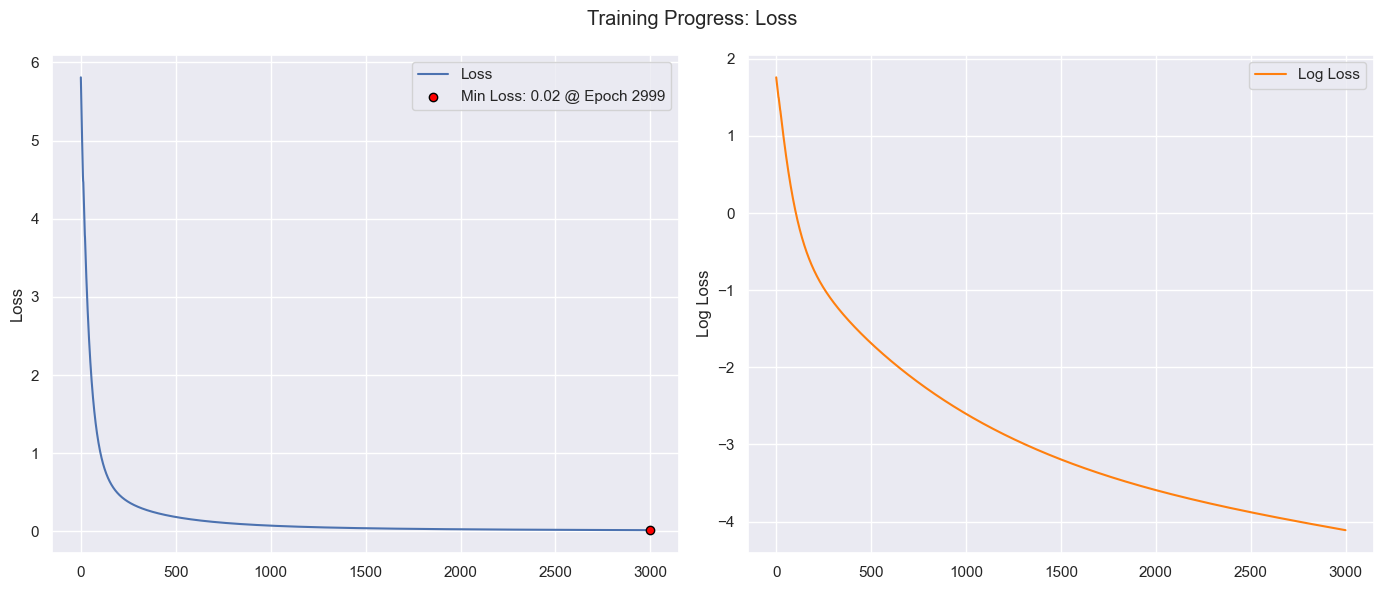

In [6]:
freq_model = FrequencyDependentModel(w_tensor=full_w, d=thickness, ICs_n=3.2, ICs_k=0.0001)

# Setup Optimizer and scheduler
optimizer_freq = torch.optim.Adam(freq_model.parameters(), lr=5e-4)

# Not used at the moment
scheduler_freq = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer_freq, mode='min', factor=0.1, patience=250)


freq_model.train_model(H_exp=freq_dep_H, Physical_model=H_th_function, loss_fn=log_complex_loss, epochs=3000, optimizer=optimizer_freq)
plot_training_progress(freq_model.loss_history)

In [7]:
n_w = freq_model.n.detach().cpu().numpy()
k_w = freq_model.k.detach().cpu().numpy()

frequencies = full_w_THz


def plot_material_params(frequencies, n, k):
    # Create the first subplot (assuming 'data1' is your first dataset)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # First plot: Approximate values of n from NR solution
    sns.scatterplot(x=frequencies, y=n, label="n values", ax=ax1)
    ax1.set_title('Approximate values of n')
    ax1.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
    ax1.set_xlabel('Frequencies [THz]')

    # Second plot (assuming 'data2' is your second dataset with x and y values)
    sns.scatterplot(x=frequencies, y=k, label="k values", ax=ax2)
    ax2.set_title('Approximate values of k')
    ax2.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
    ax2.set_xlabel('Frequencies [THz]')

    # Adjust layout and add main title if needed
    plt.suptitle('Material Parameters', y=1.02)
    plt.tight_layout()
    plt.legend()
    plt.show()

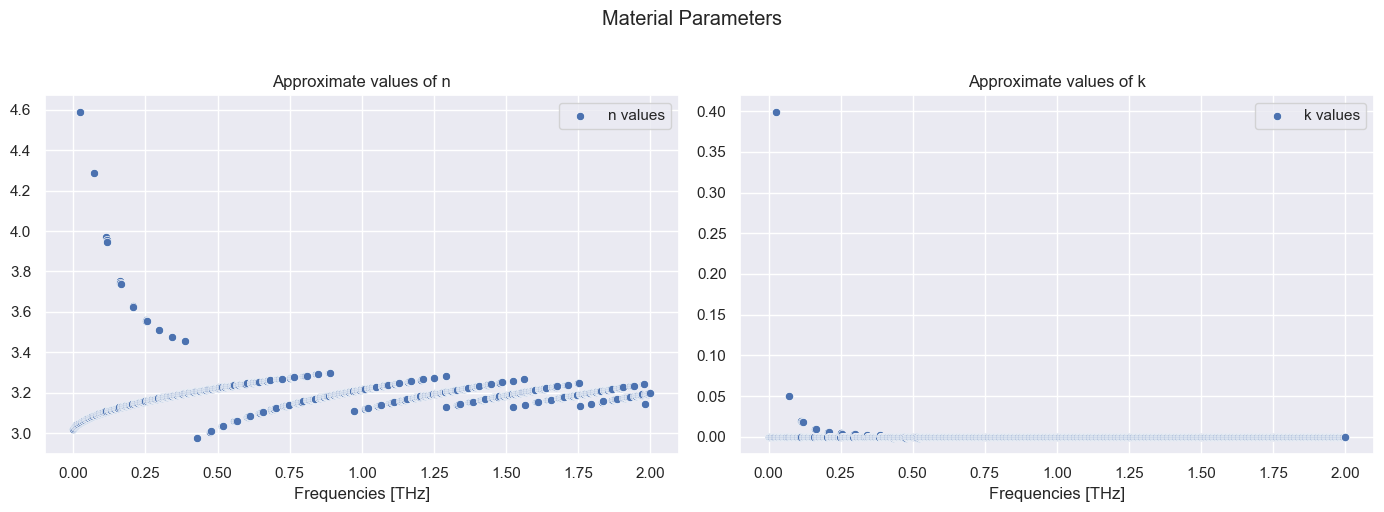

In [8]:
plot_material_params(frequencies=frequencies, n=n_w, k=k_w)

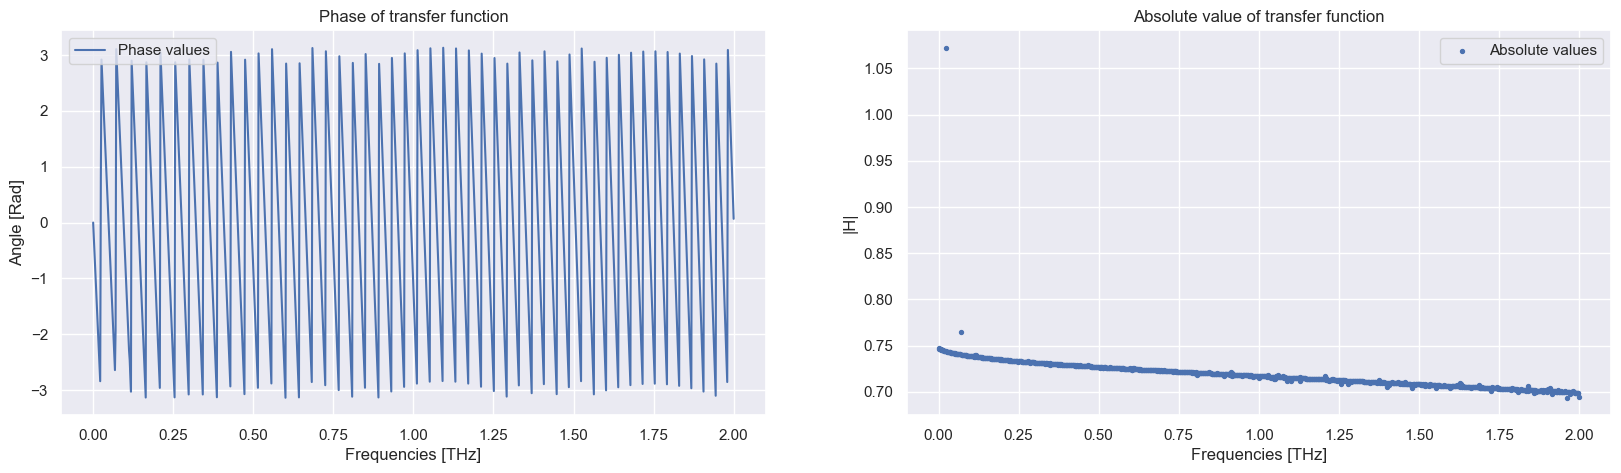

In [9]:
n_complex_w = n_w + 1j*k_w
n_complex_w = torch.tensor(n_complex_w, dtype=torch.cfloat)

H_w_recon = H_th_function(n_complex=n_complex_w, w=full_w, length=thickness)

H_w_recon_abs = torch.abs(H_w_recon)
H_w_recon_phase = torch.angle(H_w_recon)

plot_transfer(frequencies, H_w_recon_abs, H_w_recon_phase)

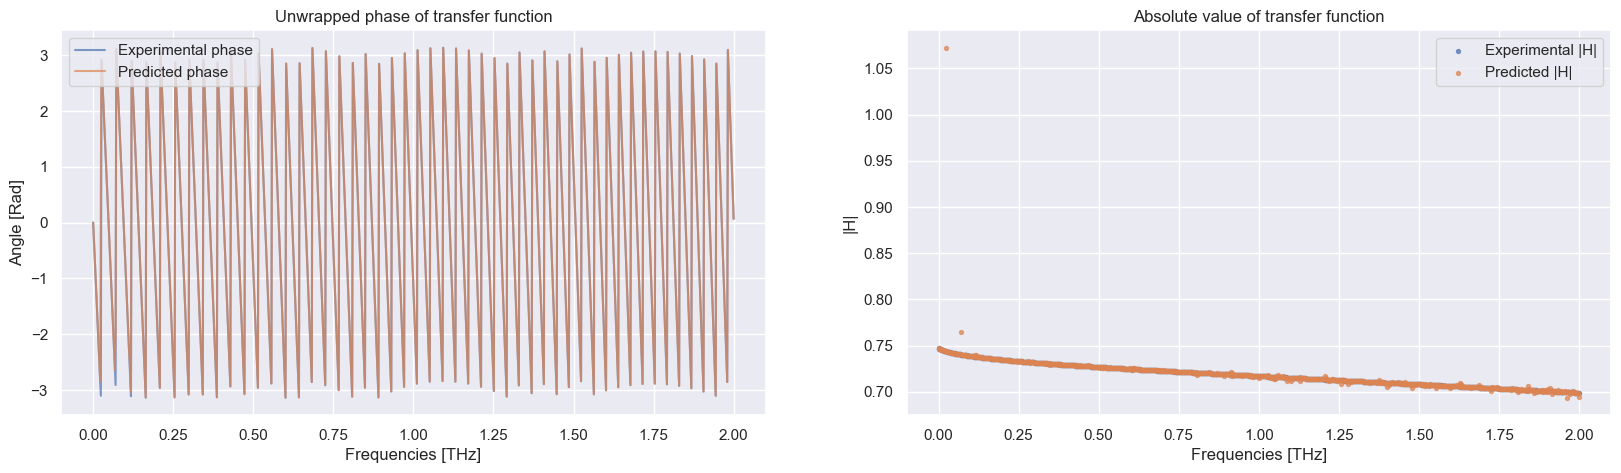

In [10]:
plot_comparison(frequencies=frequencies, exp_abs=freq_dep_H_abs, exp_phase=freq_dep_H_phase, pred_abs=H_w_recon_abs, pred_phase=H_w_recon_phase)

## Test LBFGS optimizer

Epoch 0: Loss = 5.809986591339111
Epoch 500: Loss = 3.4704818725585938
Epoch 1000: Loss = 2.06101655960083
Epoch 1500: Loss = 1.219079852104187
Epoch 2000: Loss = 0.7173682451248169
Epoch 2500: Loss = 0.41947227716445923
Epoch 3000: Loss = 0.24346618354320526
Epoch 3500: Loss = 0.1400766521692276


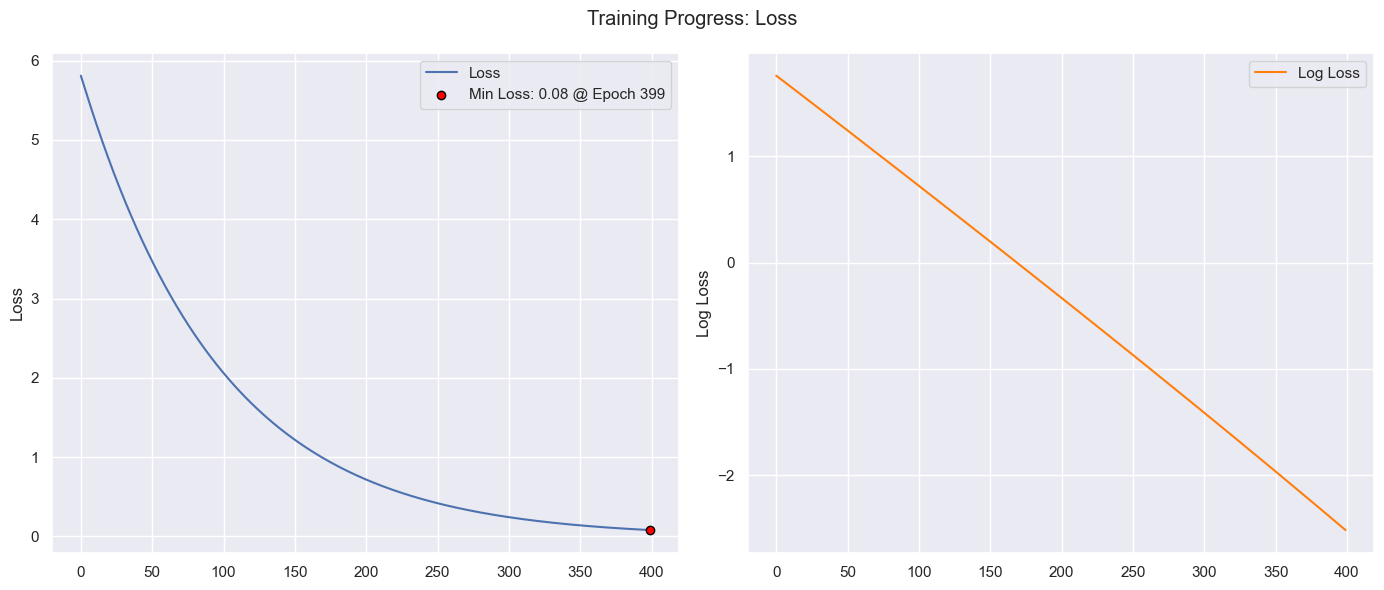

In [11]:
LBFGS_model = FrequencyDependentModel2(full_w, thickness, 3.2, 0.0001)

LBFGS_optimizer = torch.optim.LBFGS(LBFGS_model.parameters(), lr=1e-4, max_iter=5)

LBFGS_model.train_model(freq_dep_H, H_th_function, loss_fn=log_complex_loss, optimizer=LBFGS_optimizer, epochs=4000)
plot_training_progress(LBFGS_model.loss_history)

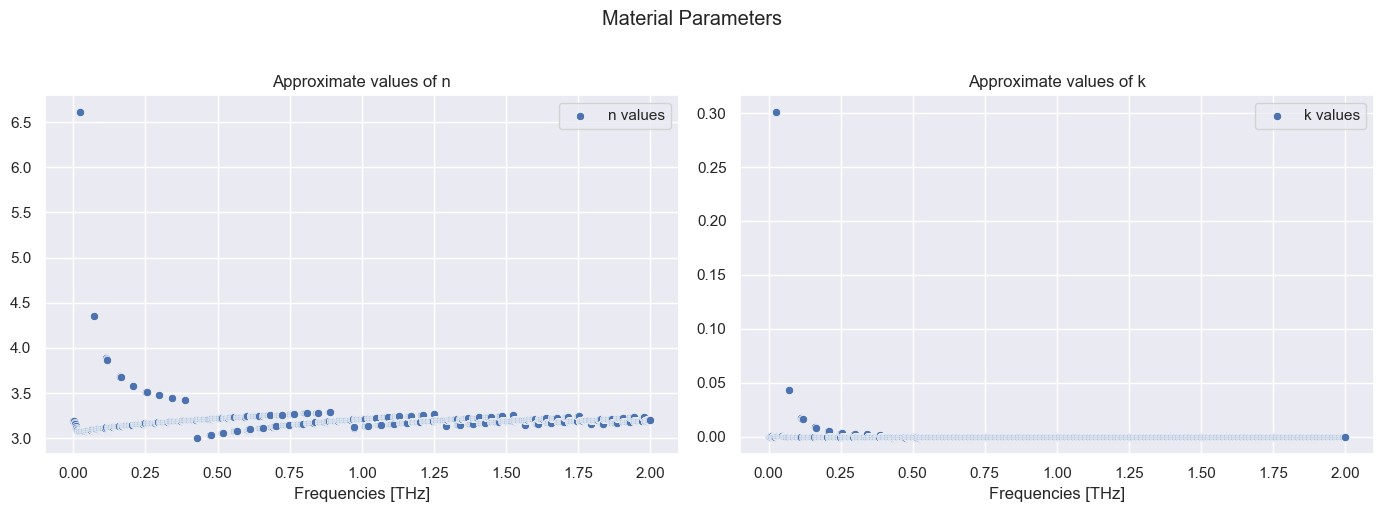

In [12]:
LBFGS_n_w = LBFGS_model.n.detach().cpu().numpy()
LBFGS_k_w = LBFGS_model.k.detach().cpu().numpy()

plot_material_params(frequencies, LBFGS_n_w, LBFGS_k_w)

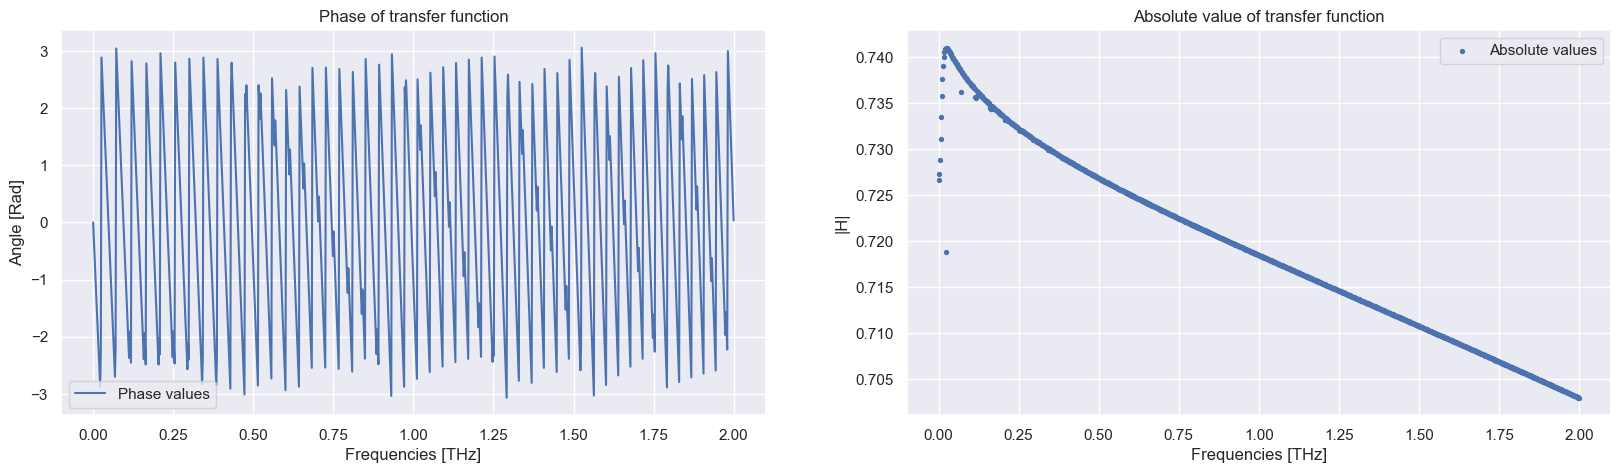

In [13]:


LBFGS_n_complex_w = LBFGS_n_w + 1j*LBFGS_k_w
LBFGS_n_complex_w = torch.tensor(LBFGS_n_complex_w, dtype=torch.cfloat)

LBFGS_recon_H =  H_th_function(n_complex=LBFGS_n_complex_w, w=full_w, length=thickness)

LBFGS_H_w_recon_abs = torch.abs(LBFGS_recon_H)
LBFGS_H_w_recon_phase = torch.angle(LBFGS_recon_H)

plot_transfer(frequencies, LBFGS_H_w_recon_abs, LBFGS_H_w_recon_phase)